# Interpretability Plots for Airfoil Test Data

This notebook shows how we produced interpretability plots for the UIUC Airfoil test data (for Section 4.3 of the paper).

For context, we have trained a convolutional autoencoder to embed images of airfoils into a low-dimensional latent space, and used both interpolation and machine learning methods to predict lift-to-drag ratios using thes embeddings.

During validation, our predictions were accurate and the interpolation methods provided error bounds that seemed to confirm our methodology.

However, when we switched to the test set, the generalization error was greater than expected and violated our interpolation error bounds.

This notebook focuses on using the interpretability of the ``Delaunay`` method to explore why we experienced this large generalization error.

Consequently, in several places we will look at just the Delaunay interpolation data/results.

## Detailed Background Information

**Context:**

In  Section 4.1, we had trained a convolutional autoencoder to embed airfoil images from the UIUC Airfoil dataset into a 4-dimensional latent space (we also considered 2D, 6D, and 8D autoencoders, but the 4D autoencoder performed best).

**Methodology**:
 - We divided our data into a train-valid-test split;
 - The training and validation sets were used to train the convolutional autoencoders;
 - Using several different interpolation methods and a ReLU MLP, we predicted the lift-to-drag ratio for each (embedded) validation point based on the (embedded) training set (using the embeddings produced by our autoencoder);
 - We confirmed that the interpolation methods (except for the Gaussian process/kriging interpolant) and the ReLU MLP performed as expected, and furthermore, all of the interpolation methods (except for the Gaussian process interpolant) produced predictions that obeyed their expected error bounds;

**The mystery:**

After validating our methods, we moved on to perform predictions with the 4D autoencoder on the test set (see Section 4.2).
 - *None of the methods above* achieved acceptable performance on the test set;
 - Furthermore, the interpolation methods produced actual errors that largely exceeded their predicted error bounds;
 - The error bounds use relatively weak assumptions about the underlying function, so we would like to investigate *why* they are not holding up on the test set, as this likely indicates a fundamental issue with our methodology.
 
**As a starting point:**

The Delaunay interpolation method uses a weighted sum of points from the training set to make each prediction. Therefore, we can import the training and test sets and investigate several test points (both the embedded and original test images) to visualize how the predictions are being made.


We can start by importing some useful modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense
from tensorflow.keras.models import Model
import csv

2024-02-25 18:29:21.397147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Investigating the Test Images

We want to look at the training images, the test images, and the *decoded* latent space images.

To do so, we will need to be able to decode points from the latent space back into the original (pixel) space.

We can load the weights file for the decoder from our airfoil image autoencoder.

In [2]:
decoder = tf.keras.models.load_model('../data/decoder_model.h5')

We can use the decoder model to extract the original airfoil images from the latent space.

*Note: These are not the true original airfoil images, they are the encoded then decoded representations of the original images. If the encoder and decoder are accurate, then these should be similar to the original images.*

In [3]:
latent_space_train = np.load('../data/Dim_4/Latent_space_train.npy')
latent_space_test = np.load('../data/Dim_4/Latent_space_test.npy')
decoded_train = decoder.predict(latent_space_train)
decoded_test = decoder.predict(latent_space_test)

22/22 [==============================] - 1s 32ms/step


For comparison, we can also load the true training and testing images. Due to size restrictions, these are not included in the GitHub download. However, they can be fetched from
  https://github.com/thchang/uiuc_full_space
and saved into the appropriate directory (``../data/``).

In [4]:
true_train = np.load('../data/Full_space_train.npy')
true_test = np.load('../data/Full_space_test.npy')

Now let's create some helper functions.

Since some of our interpolation methods are either undefined or experience numerical issues when given redundant training points, we have averaged the response values for any training points that were the same up to a tolerance in the latent space. This was done **before** making any predictions.

In order to evaluate interpretability with respect to the original training set, we need to undo this "pooling" operation. To help with this, the file ``af_index.csv`` lists training points that were averaged together in the latent space. We will use this file to undo the pooling operation.

In [5]:
def getTrainWeights(ind, weight):
    """ A helper function that takes indices and weights for a simplex in the latent space
    and returns the corresponding indices and weights from the original (pixel) input space.
    
    Args:
        ind (int): An integer index corresponding to a training image in the latent space (0 based)
        weight (float): A float between 0 and 1 corresponding to the prediction weight on the above image
        
    Returns:
        train_inds, train_weights: The true training indices and weights corresponding to the above latent image
    
    """

    train_inds = []
    train_weights = None
    with open("../data/Dim_4/af_index.csv", "r") as fp:
        csv_reader = csv.reader(fp)
        for i, rowi in enumerate(csv_reader):
            if i == ind:
                for col in rowi:
                    train_inds.append(int(col))
                    if weight is not None:
                        train_weights = weight / len(rowi)
                break        
    return train_inds, train_weights

Finally, to make plotting the results easier, let's define a helper function for plotting that also sets an appropriate image style.

We'll use the ``getTrainWeights`` helper function from above to automatically get the true training image indices whenever the image type is set to use the "true" training images, otherwise, we'll just plot the given index and weight.

In [6]:
def plt_show(index, weight=None, im_type="decoded_train"):
    """ Show the current image and its corresponding weights.
    
    Args:
        index (int): The index of this image in the true training set.
        weight (float): The weight that this image was given for the prediction. Can be None to go unused.
        im_type (str, optional): Specifies which data set to plot from.
    
    """

    if im_type == "true_train":
        inds, weights = getTrainWeights(index, weight)
        images = true_train
        im_cap = "True training image"
    elif im_type == "decoded_train":
        inds, weights = getTrainWeights(index, weight)
        images = decoded_train
        im_cap = "Decoded training image"
    elif im_type == "true_test":
        inds, weights = [index], None
        images = true_test
        im_cap = "True test image"
    elif im_type == "decoded_test":
        inds, weights = [index], None
        images = decoded_test
        im_cap = "Decoded test image"
    for ind in inds:
        plt.imshow(images[ind])
        if weights is not None:
            plt.text(0.5, 4, f"Image type: {im_cap}\tImage weight: {weights}", fontsize=8)
        else:
            plt.text(0.5, 4, f"Image type: {im_cap}", fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.show()

The actual performance data for the 4D test case was saved in file ``../results/airfoil_latent4D_test_log_2024-02.csv``.

We will load the ``csv`` file and extract the ``Delaunay`` rows and all relevant columns for analysis. Specifically, the relevant columns include:
 - Was the prediction in the convex hull of the (latent space) training data?
 - What was the predicted bound for the Delaunay method?
 - What was the actual error for this particular prediction?
 - What was the simplex (indices of training points) used to make this prediction?
 - What were the weights for the above training points?

In [7]:
in_hull_test = []
bounds_test = []
errors_test = []
simps_test = []
weights_test = []

with open("../results/airfoil_latent4D_test_log_2024-02.csv", "r") as fp:
    csv_reader = csv.reader(fp)
    for row in csv_reader:
        if row[0] == "Delaunay":
            in_hull_test.append(int(row[1]))
            bounds_test.append(float(row[2][1:-1]))
            errors_test.append(float(row[3][1:-1]))
            simps_test.append([int(j.strip()) for j in row[4][1:-1].strip().split()])
            weights_test.append([float(j.strip()) for j in row[5][1:-1].strip().split()])

# We've commented them out, but you can uncomment below to check the values of
# in_hull, bounds, errors, simps, and weights below...
# print(in_hull_test)
# print(bounds_test)
# print(errors_test)
# print(simps_test)
# print(weights_test)

Now, let's check that the decoded latent space images and original training images visually match for each prediction. If not, then there may be an issue in our training pipeline.

**First:**
We'll look at the *most* accurate prediction in the test set, where the test embedding was an *interpolation point* and the true error was *within* the Delaunay error bounds.

[4879, 369, 465, 173, 1616] [0.21798025, 0.38269338, 0.00522047, 0.25512498, 0.13898092]
Test images (decoded in green, true in yellow):


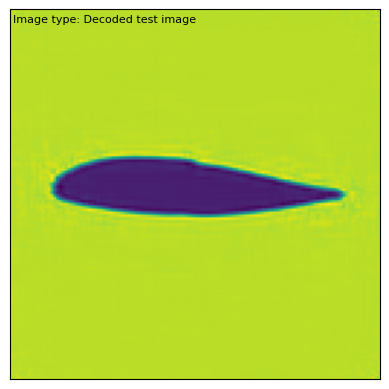

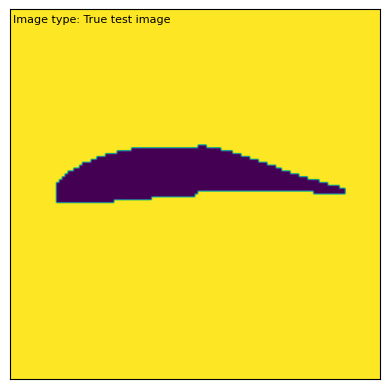

Training images used in prediction (decoded in green, true in yellow):


/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


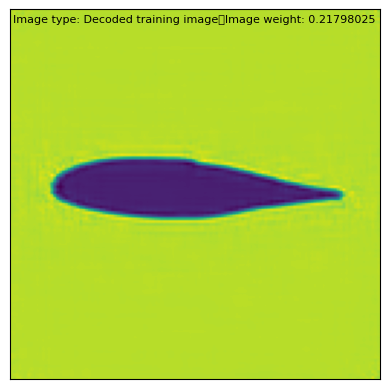

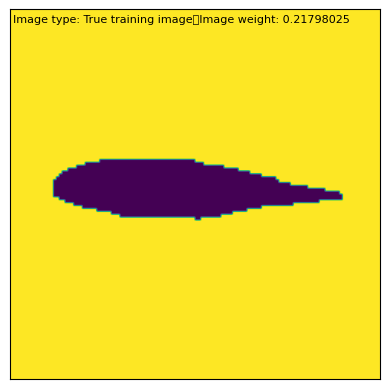

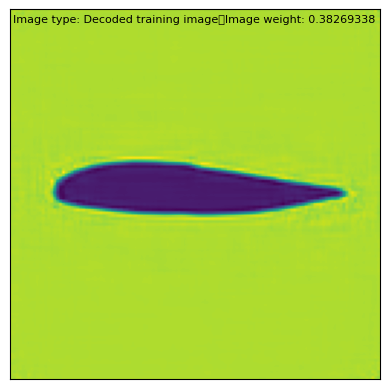

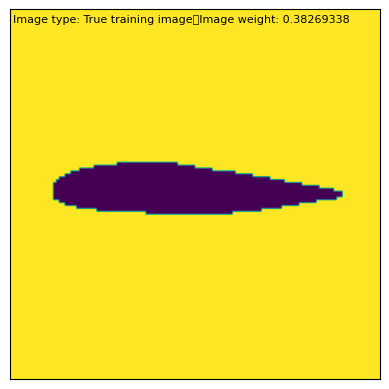

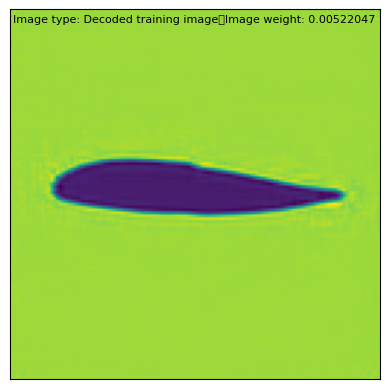

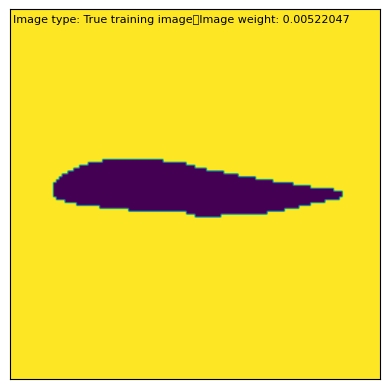

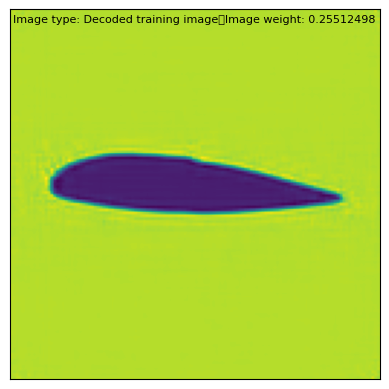

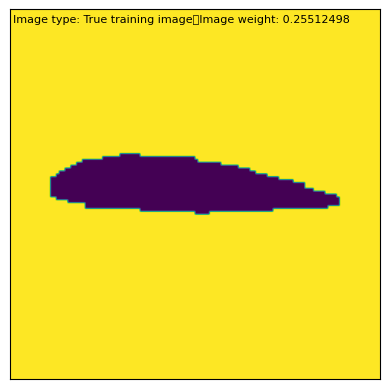

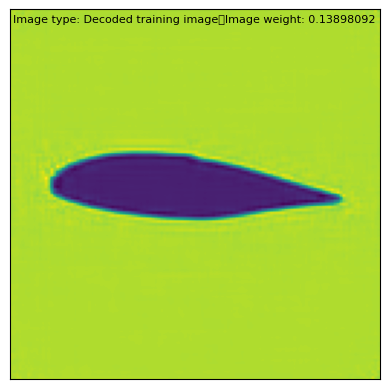

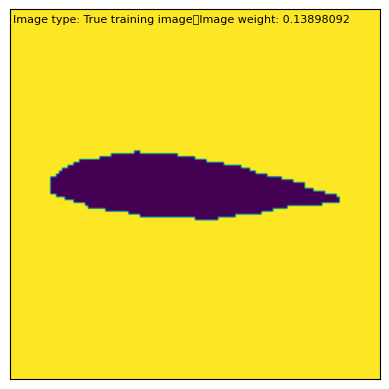

In [8]:
i_m = 0; e_m = 0.15; b_m = 0.15; simp_m = None; weights_m = None

for i, hi in enumerate(in_hull_test):
    ei = errors_test[i]
    bi = bounds_test[i]
    if hi == 1 and ei < bi:
        if ei < e_m:
            i_m = i
            e_m = ei
            b_m = bi
            simp_m = simps_test[i]; weights_m = weights_test[i]

print(simp_m, weights_m)

print("Test images (decoded in green, true in yellow):")

plt_show(i_m, im_type="decoded_test")
plt_show(i_m, im_type="true_test")

print("Training images used in prediction (decoded in green, true in yellow):")

for si, wi in zip(simp_m, weights_m):
    if wi > 1.0e-8:
        plt_show(si, wi, "decoded_train")
        plt_show(si, wi, "true_train")

We see above that while the training image embeddings remain high-quality, the test image's embedding is significantly degraded. Still, some aspects of the test image are correctly embedded (such as the angle-of-attack) and the embedding resembles the embeddings of the relevant embedded training images.

**Next:**
We'll look at the *least* accurate prediction in the test set, where the test embedding was still an *interpolation point* but the true error exceeds the Delaunay error bounds.

[4811, 1685, 5144, 1258, 2263] [0.47703528, 0.05229255, 0.37642206, 0.09265479, 0.00159533]
Test images (decoded in green, true in yellow):


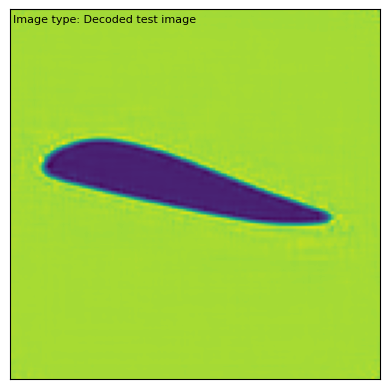

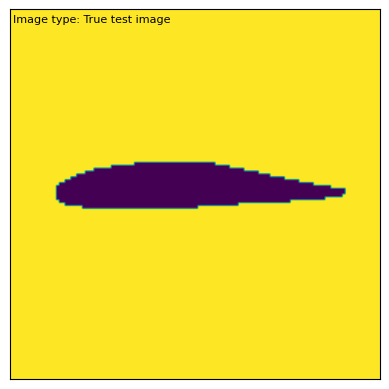

Training images used in prediction (decoded in green, true in yellow):


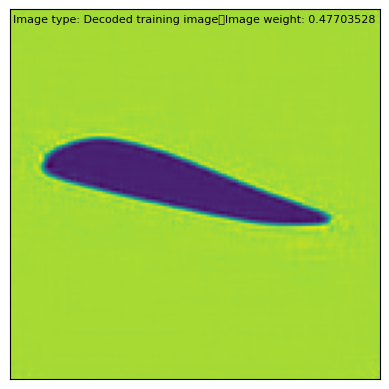

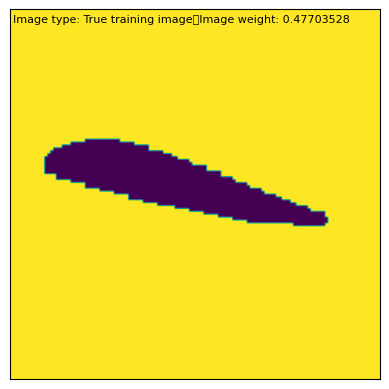

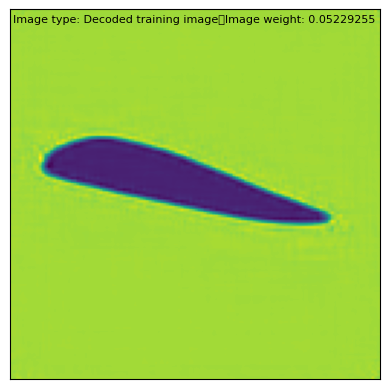

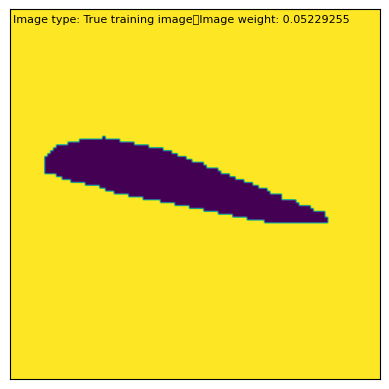

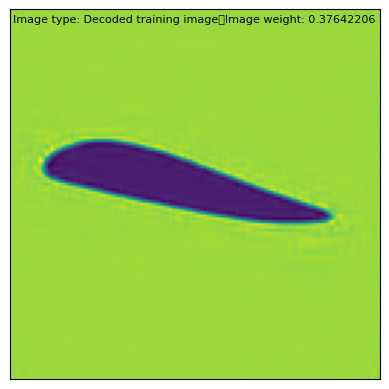

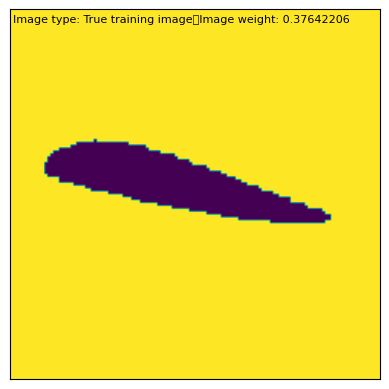

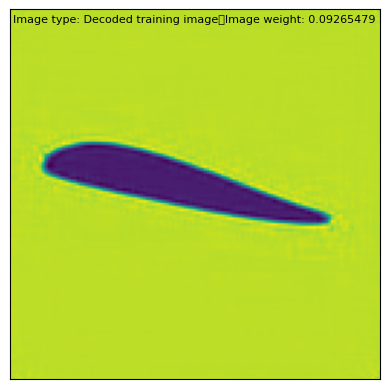

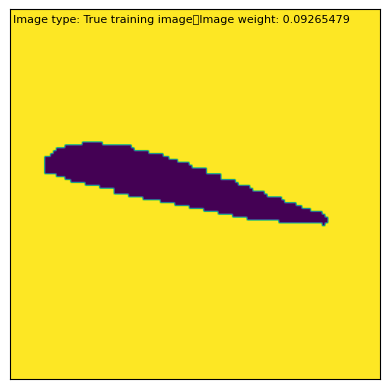

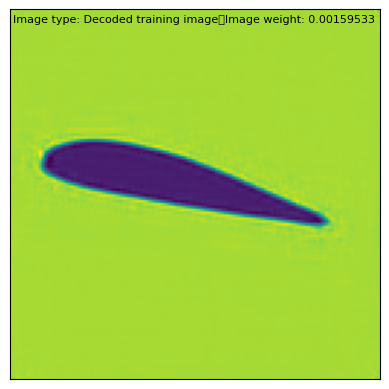

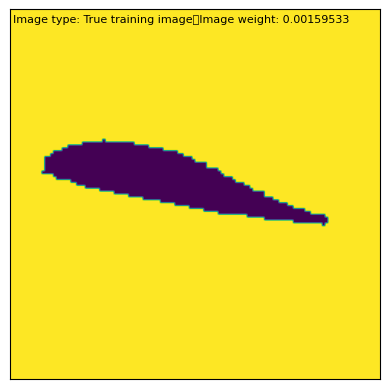

In [9]:
i_m = 0; e_m = 0.15; b_m = 0.15; simp_m = None; weights_m = None

for i, hi in enumerate(in_hull_test):
    ei = errors_test[i]
    bi = bounds_test[i]
    if hi == 1 and ei > bi:
        if ei > e_m:
            i_m = i
            e_m = ei
            b_m = bi
            simp_m = simps_test[i]; weights_m = weights_test[i]

print(simp_m, weights_m)

print("Test images (decoded in green, true in yellow):")

plt_show(i_m, im_type="decoded_test")
plt_show(i_m, im_type="true_test")

print("Training images used in prediction (decoded in green, true in yellow):")

for si, wi in zip(simp_m, weights_m):
    if wi > 1.0e-8:
        plt_show(si, wi, "decoded_train")
        plt_show(si, wi, "true_train")

We see above that this time the test image's embedding has very little visual similarity to the true test image. The training embeddings remaing high-quality and bear visual similarity to the test image's embedding (but not to the true test image). This likely explains why the Delaunay method's error bound broke down, and indicates that the trained encoder-decoder pair, while accurate on the training and validation set, did not generalize well to the test set.

**Last:**
We'll look at the *least* accurate prediction in the test set, where the test embedding was flagged as an *extrapolation point* and the true error still exceeded the Delaunay error bounds.

[5338, 4455, 3192, 388, 4121] [0.680604238, 0.150917318, 1.171318e-16, 0.168478444, -2.3794045e-15]
Test images (decoded in green, true in yellow):


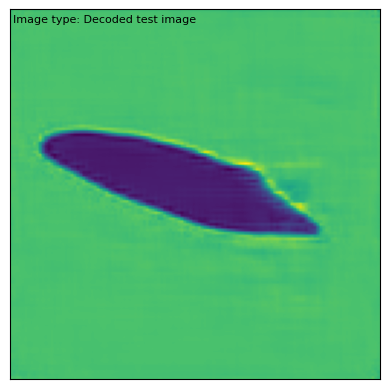

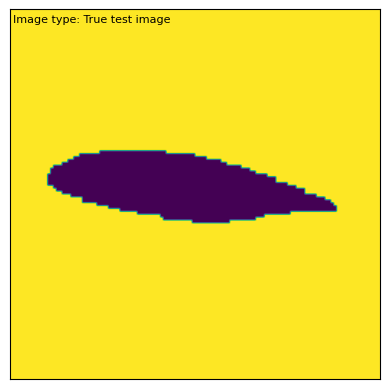

Training images used in prediction (decoded in green, true in yellow):


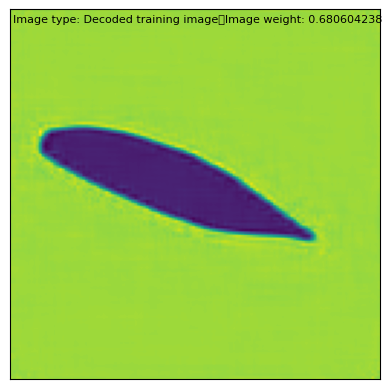

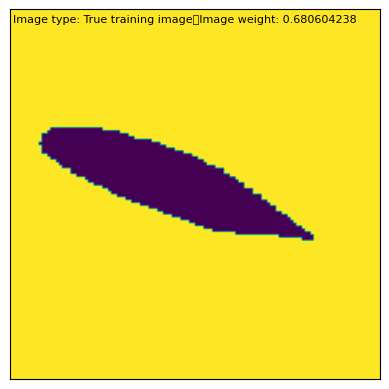

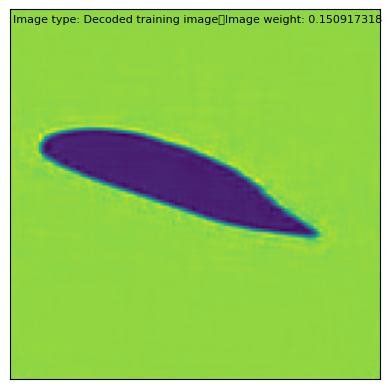

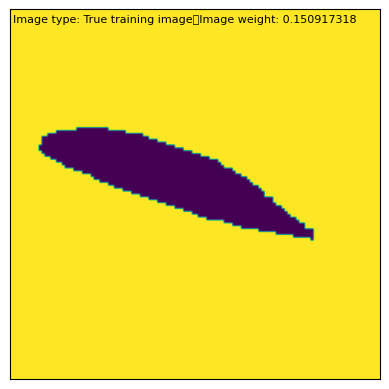

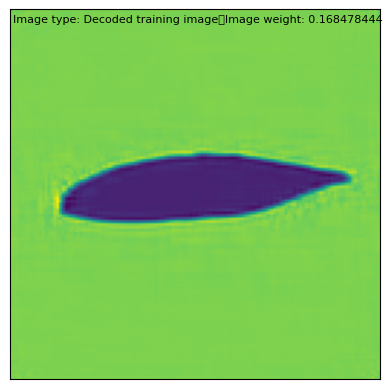

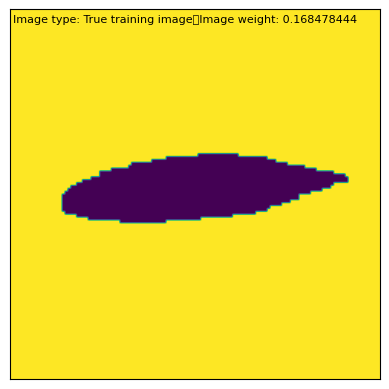

In [10]:
i_m = 0; e_m = 0.15; b_m = 0.15; simp_m = None; weights_m = None

for i, hi in enumerate(in_hull_test):
    ei = errors_test[i]
    bi = bounds_test[i]
    if hi == 0 and ei > bi:
        if ei > e_m:
            i_m = i
            e_m = ei
            b_m = bi
            simp_m = simps_test[i]; weights_m = weights_test[i]

print(simp_m, weights_m)

print("Test images (decoded in green, true in yellow):")

plt_show(i_m, im_type="decoded_test")
plt_show(i_m, im_type="true_test")

print("Training images used in prediction (decoded in green, true in yellow):")

for si, wi in zip(simp_m, weights_m):
    if wi > 1.0e-8:
        plt_show(si, wi, "decoded_train")
        plt_show(si, wi, "true_train")

This time, not only does the test image's embedding not resemble the test image, it is distorted in such a way that it does not match a physical airfoil. Therefore, it also does not visually match any of the embedded training images used to make the prediction. This is likely why the prediction error was high. However, because the embedding was completely *outside of the training sample*, the Delaunay method was able to flag it as an extrapolation point.

**In summary:**
We have looked at several different images (and their latent space decodings) from the test set in order to understand why we are experienceing such a significant performance decrease on the test set, and why the interpolation methods' error bounds are breaking down.

**Our hypothesis** is that the convolutional autoencoder that we trained in a previous Section did not generalize well to the test set.

## Double-Checking on the Validation Set

To test that hypothesis, let's look at its performance on the validation set and see if the embeddings were higher quality.

We can start by loading the true validation images and decoding the latent validation images, similarly as we did above.

In [11]:
true_val = np.load('../data/Full_space_val.npy')
latent_space_val = np.load('../data/Dim_4/Latent_space_val.npy')
decoded_val = decoder.predict(latent_space_val)

20/20 [==============================] - 1s 34ms/step


We can re-use the majority of the code from above, we just need to re-define the ``plt_show`` function in order to provide additional options for plotting the validation sets.

In [12]:
def plt_show(index, weight=None, im_type="decoded_train"):
    """ Show the current image and its corresponding weights.
    
    Args:
        index (int): The index of this image in the true training set.
        weight (float): The weight that this image was given for the prediction. Can be None to go unused.
        im_type (str, optional): Specifies which data set to plot from.
    
    """

    if im_type == "true_train":
        inds, weights = getTrainWeights(index, weight)
        images = true_train
        im_cap = "True training image"
    elif im_type == "decoded_train":
        inds, weights = getTrainWeights(index, weight)
        images = decoded_train
        im_cap = "Decoded training image"
    elif im_type == "true_test":
        inds, weights = [index], None
        images = true_test
        im_cap = "True test image"
    elif im_type == "decoded_test":
        inds, weights = [index], None
        images = decoded_test
        im_cap = "Decoded test image"
    elif im_type == "true_val":
        inds, weights = [index], None
        images = true_val
        im_cap = "True validation image"
    elif im_type == "decoded_val":
        inds, weights = [index], None
        images = decoded_val
        im_cap = "Decoded validation image"
    for ind in inds:
        plt.imshow(images[ind])
        if weights is not None:
            plt.text(0.5, 4, f"Image type: {im_cap}\tImage weight: {weights}", fontsize=8)
        else:
            plt.text(0.5, 4, f"Image type: {im_cap}", fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.show()

Next we will open the actual performance data for the 4D validation experiments, which was saved in file
``../results/airfoil_latent4D_valid_log_2024-02.csv``.
  
We will load the csv file and extract the Delaunay rows and all relevant columns for analysis. The relevant columns are the same as before:
 - Was the prediction in the convex hull of the (latent space) training data?
 - What was the predicted bound for the Delaunay method?
 - What was the actual error for this particular prediction?
 - What was the simplex (indices of training points) used to make this prediction?
 - What were the weights for the above training points?

In [13]:
in_hull_val = []
bounds_val = []
errors_val = []
simps_val = []
weights_val = []

with open("../results/airfoil_latent4D_valid_log_2024-02.csv", "r") as fp:
    csv_reader = csv.reader(fp)
    for row in csv_reader:
        if row[0] == "Delaunay":
            in_hull_val.append(int(row[1]))
            bounds_val.append(float(row[2][1:-1]))
            errors_val.append(float(row[3][1:-1]))
            simps_val.append([int(j.strip()) for j in row[4][1:-1].strip().split()])
            weights_val.append([float(j.strip()) for j in row[5][1:-1].strip().split()])

# We've commented them out, but you can uncomment below to check the values of
# in_hull, bounds, errors, simps, and weights below...
# print(in_hull_val)
# print(bounds_val)
# print(errors_val)
# print(simps_val)
# print(weights_val)

Again, let's check that the decoded latent space images and original training images visually match for each prediction.

Similarly as before, we'll look at the most accurate interpolation point, the least accurate interpolation point, and the least accurate extrapolation point.

One minor change from before: there are *no* points that violate the Delaunay error bounds in the validation set. However, there are validation points that are also in the test set (which makes for an un-interesting prediction).
Therefore, we will only extract points where the predicted error bound is greater than $10^{-4}$, in order to avoid such points.

**First:**
We'll look at the *most* accurate prediction in the validation set where the validation point's embedding was an *interpolation point*.

[4471, 490, 5008, 4880, 3443] [0.20681834, 0.1101686, 0.61238944, 0.02785523, 0.04276839]
Validation images (decoded in green, true in yellow):


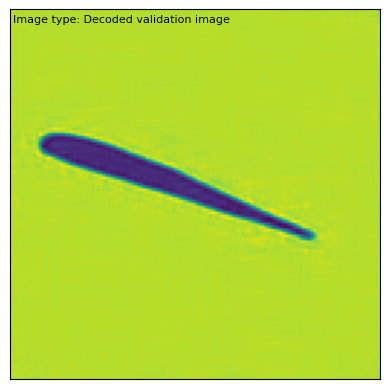

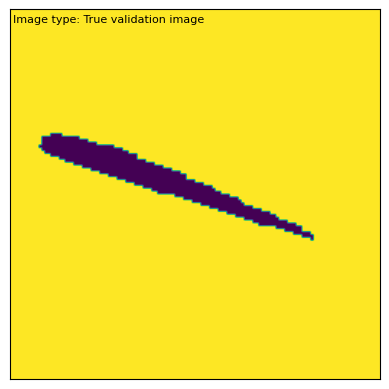

Training images used in prediction (decoded in green, true in yellow):


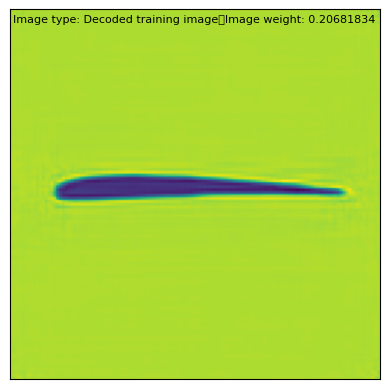

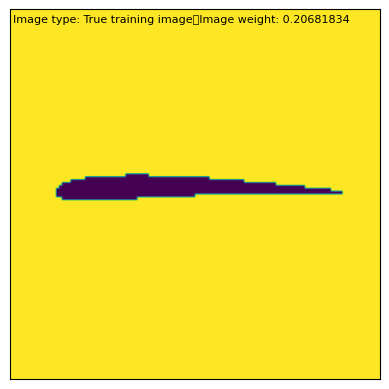

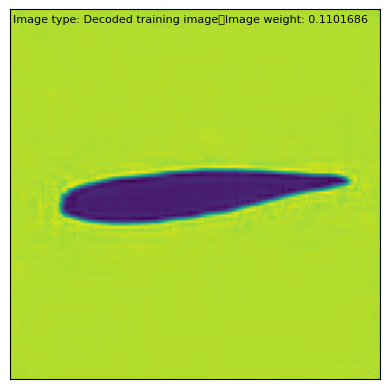

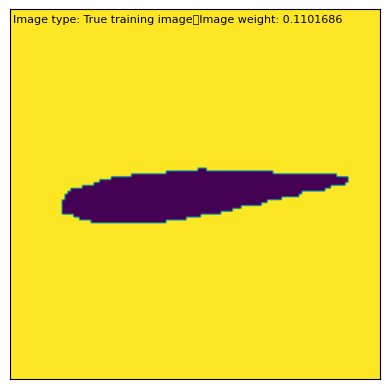

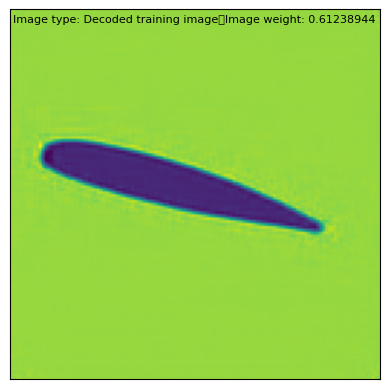

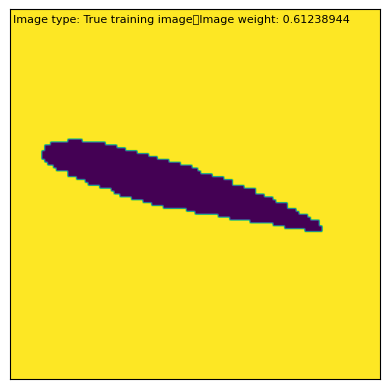

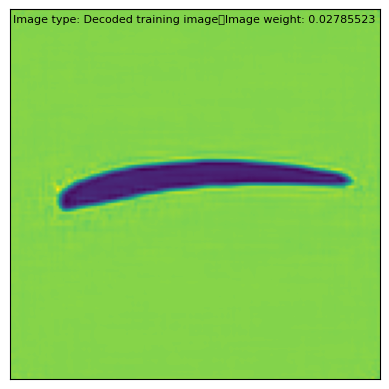

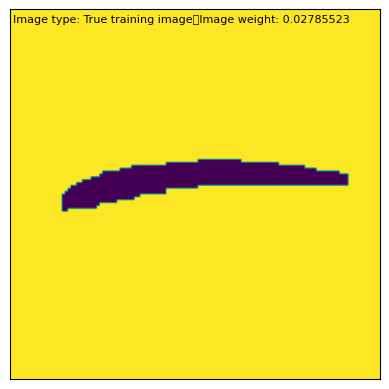

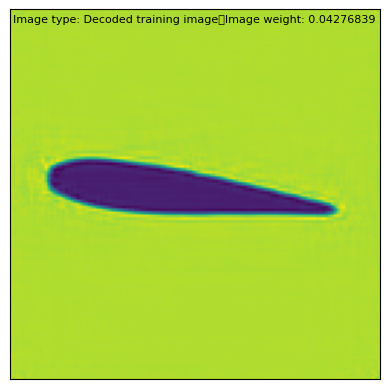

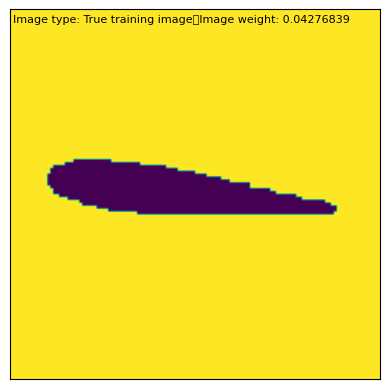

In [14]:
i_m = 0; e_m = 0.15; simp_m = None; weights_m = None

for i, hi in enumerate(in_hull_val):
    ei = errors_val[i]
    bi = bounds_val[i]
    if hi == 1 and bi > 1.0e-4:
        if ei < e_m:
            i_m = i
            e_m = ei
            simp_m = simps_val[i]; weights_m = weights_val[i]

print(simp_m, weights_m)

print("Validation images (decoded in green, true in yellow):")

plt_show(i_m, im_type="decoded_val")
plt_show(i_m, im_type="true_val")

print("Training images used in prediction (decoded in green, true in yellow):")

for si, wi in zip(simp_m, weights_m):
    if wi > 1.0e-8:
        plt_show(si, wi, "decoded_train")
        plt_show(si, wi, "true_train")

We see that both the training image and validation images' embeddings are visually high-quality.
Furthermore, the validation point matches the shape of certain training embeddings and angle of others.
This is what we might expect to see for a working machine learning pipeline.

**Next:**
We'll look at the *least* accurate prediction in the validation set where the validation point's embedding was still an *interpolation point*.

[2149, 4574, 787, 3465, 3503] [0.29738072, 0.07896621, 0.15782984, 0.3923944, 0.07342883]
Validation images (decoded in green, true in yellow):


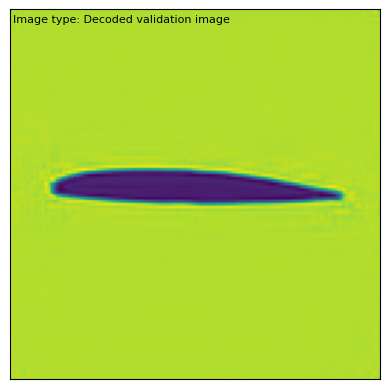

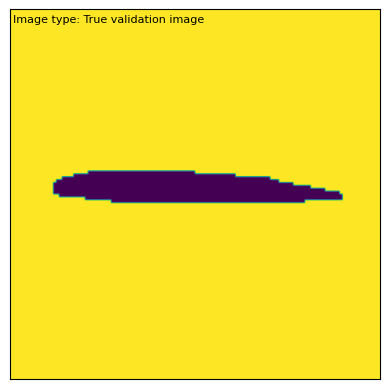

Training images used in prediction (decoded in green, true in yellow):


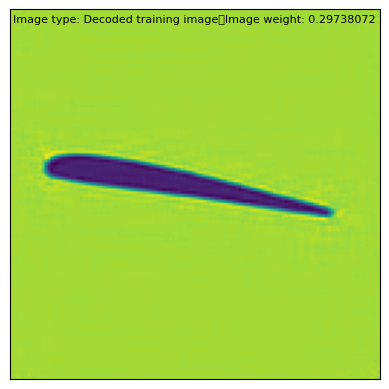

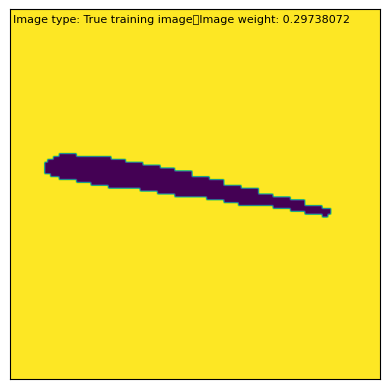

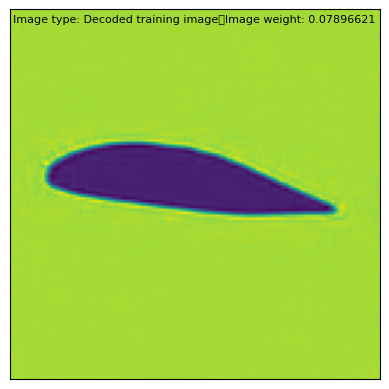

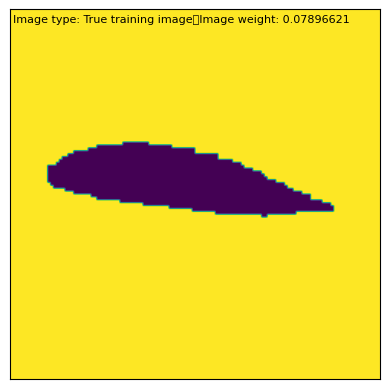

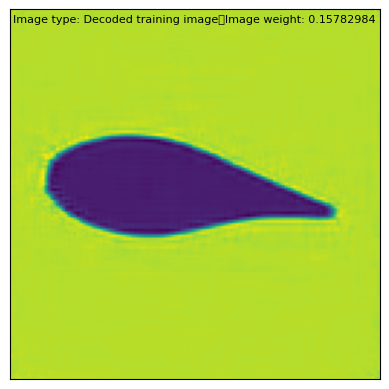

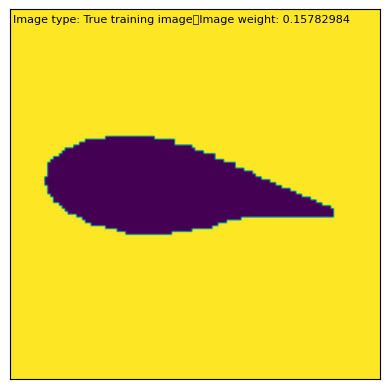

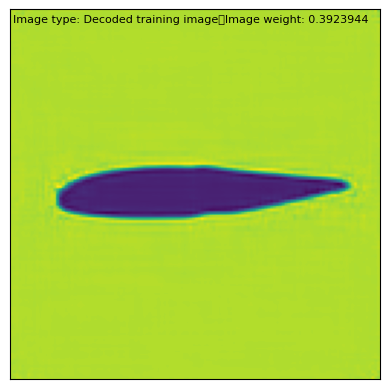

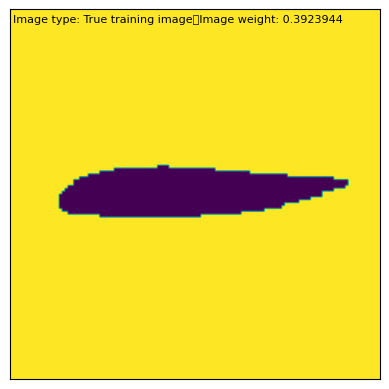

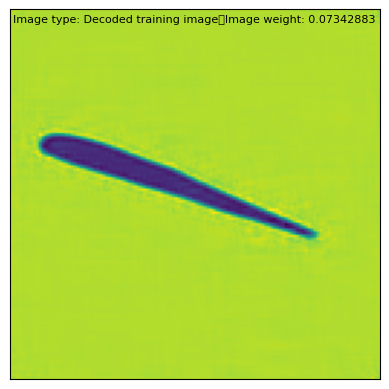

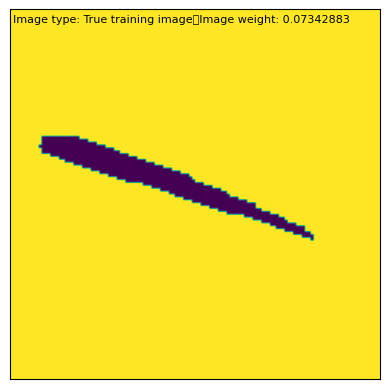

In [15]:
i_m = 0; e_m = 0.01; simp_m = None; weights_m = None

for i, hi in enumerate(in_hull_val):
    ei = errors_val[i]
    bi = bounds_val[i]
    if hi == 1 and bi > 1.0e-4:
        if ei > e_m:
            i_m = i
            e_m = ei
            simp_m = simps_val[i]; weights_m = weights_val[i]

print(simp_m, weights_m)

print("Validation images (decoded in green, true in yellow):")

plt_show(i_m, im_type="decoded_val")
plt_show(i_m, im_type="true_val")

print("Training images used in prediction (decoded in green, true in yellow):")

for si, wi in zip(simp_m, weights_m):
    if wi > 1.0e-8:
        plt_show(si, wi, "decoded_train")
        plt_show(si, wi, "true_train")

Again, we see that both the training image and validation images' embeddings are visually high-quality.
There is no glaring difference between the predictions for this validation point and the previous validation point.
Since both predictions remain within the error bounds there is no reason to think that anything is wrong, even  though the prediction error is slightly larger here.

**Finally:**
We'll look at the *least* accurate prediction in the validation set where the validation point's embedding was still an *extrapolation point*.

[4471, 310, 4323, 1339, 1955] [0.23418047, 0.349887955, 0.299562492, 0.116369083, -1.60014296e-13]
Validation images (decoded in green, true in yellow):


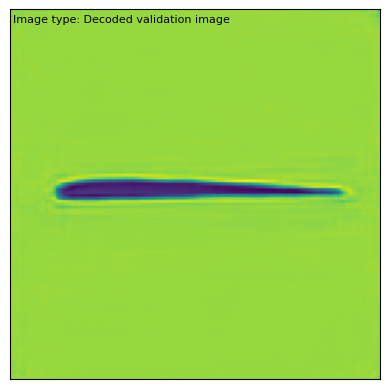

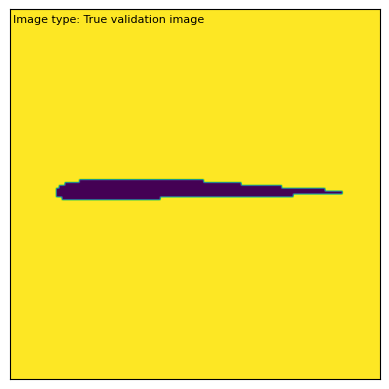

Training images used in prediction (decoded in green, true in yellow):


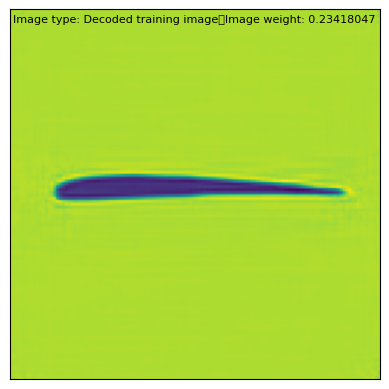

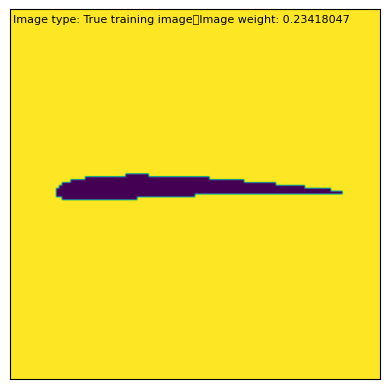

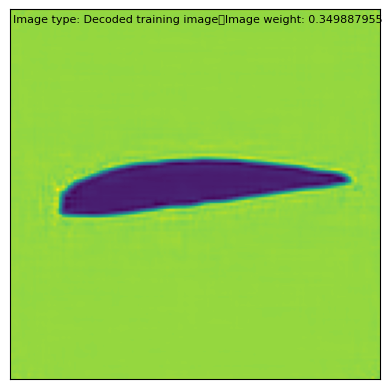

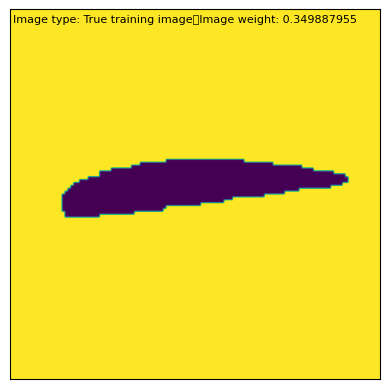

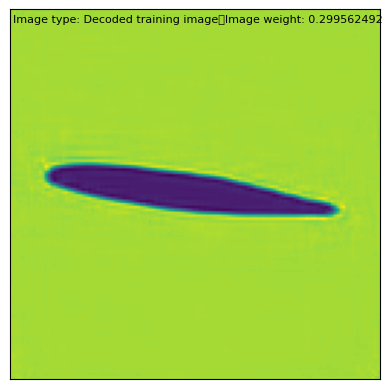

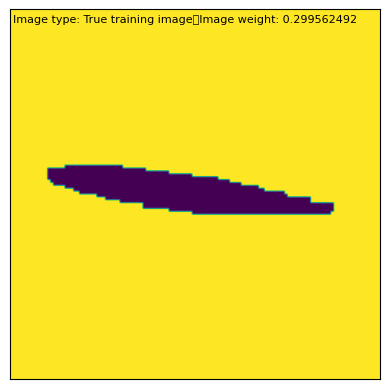

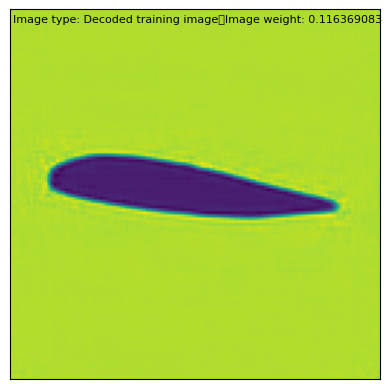

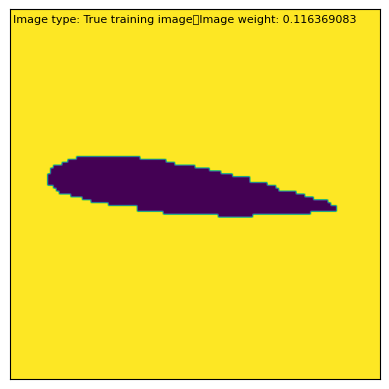

In [16]:
i_m = 0; e_m = 0.01; simp_m = None; weights_m = None

for i, hi in enumerate(in_hull_val):
    ei = errors_val[i]
    bi = bounds_val[i]
    if hi == 0 and bi > 1.0e-4:
        if ei > e_m:
            i_m = i
            e_m = ei
            simp_m = simps_val[i]; weights_m = weights_val[i]

print(simp_m, weights_m)

print("Validation images (decoded in green, true in yellow):")

plt_show(i_m, im_type="decoded_val")
plt_show(i_m, im_type="true_val")

print("Training images used in prediction (decoded in green, true in yellow):")

for si, wi in zip(simp_m, weights_m):
    if wi > 1.0e-8:
        plt_show(si, wi, "decoded_train")
        plt_show(si, wi, "true_train")

In the above example, the validation point is slightly peculiar looking (extremely thin), but its embedding is accurate.
Furthermore, even though it is an extrapolation point (e.g., this could be an indicator for statistically "out-of-training-sample"), one of the training images used in the prediction is visually similar.
Again, there are no red flags to make us think anything is wrong here.

**In conclusion:**
It would be reaosonable to conclude that the embeddings were high quality on the training and validation points, but did not generalize to the test set.
This would explain the violation of interpolation error bounds on the test set, since these bounds assume that the mapping from the latent space to the quantity-of-interest (in this case, the lift-to-drag ratio) is continuous, which is not true when our autoencoder begins to break down.


## Summary of Findings

Our overall conclusion from this investigation is that the convolutional autoencoder that we trained on the training and validation images did not generalize well to the test set.

This may be an error of our machine learning methodology or a fundamental distribution shift between the training and testing sets.

However, investigating the results through the lens of interpolation was a useful tool for diagnosing the issue.